In [67]:
import re
import nltk
import string

import pandas as pd
import datetime as dt
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

from pandas.plotting import scatter_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.decomposition import PCA

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet, brown, words
from collections import Counter

from gensim.models import Word2Vec

from bokeh.plotting import *
from bokeh.models import *
from bokeh.layouts import column, row
from bokeh.palettes import Category20

nltk.download('stopwords')  
nltk.download('words')

[nltk_data] Downloading package stopwords to /Users/Jean-
[nltk_data]     BaptistePROST/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/Jean-
[nltk_data]     BaptistePROST/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
data='Data/russian-troll-tweets/IRAhandle_tweets_'
pickle_files='Pickles/'
WORD_FREQ = 'Data/wordfrea.xlsx'
plot_files='Plots/'

# Introduction
This part focuses on the textual content and representation of the tweets. The aim is to characterize the typical tweet of each troll category. First, the tweets are cleaned, a vocabulary as well as a colelction of hash-tags are build. Then a Word2Vec model is used to gather words by 'concepts'. Finally, each tweet is represented by the words it contains. A classifier is build to distinguish right and left trolls. 

# Preprocessing

## Data import and cleaning

The data is already pretty clean. We Select only the 'LeftTroll' and 'RightTroll' tweet after 2014.

In [4]:
def get_date(x):
    """From string to datatime.date()"""
    return dt.datetime.strptime(x, '%m/%d/%Y %H:%M').replace(minute=0, hour=0, second=0)

def cleaning_content(df,  right=True, left=True):
    df_tmp=df[df.language=='English'].drop(columns={'harvested_date', 'language'})
    df_tmp=df.loc[:,['publish_date','content', 'account_category', 'author']]

    #category
    if not left:
        df_tmp=df_tmp[(df_tmp.account_category=='RightTroll')]
    elif not right:
        df_tmp=df_tmp[(df_tmp.account_category=='LeftTroll')]
    else:        
        df_tmp=df_tmp[(df_tmp.account_category=='RightTroll') | (df_tmp.account_category=='LeftTroll')  ]

    #date 
    df_tmp['publish_date']=df_tmp.publish_date.apply(lambda x: get_date(x))
    #selecting after Oct 2014
    df_tmp=df_tmp[df_tmp.publish_date > dt.datetime(2014,10,1,0,0,0)]

    return df_tmp

Loading the data and merging (9) datasets.

In [168]:
df=pd.DataFrame()
for dataset in range(1,9): #loading every file 
    df_tmp=cleaning_content(pd.read_csv(data+str(dataset)+'.csv'))
    df=df.append(df_tmp, ignore_index=True)

Number of different trolls

In [169]:
print('There are {} trolls: {} right and {} left.'.format(df.author.unique().shape[0],\
                                                          df[df.account_category=='RightTroll'].author.unique().shape[0],\
                                                          df[df.account_category=='LeftTroll'].author.unique().shape[0]))
df.drop(columns='author', inplace=True)

There are 850 trolls: 620 right and 230 left.


Number of unique tweets

In [170]:
print('From {} tweets, {} are unique ({} tweets are duplicated).'\
      .format(df.shape[0],df.content.unique().shape[0],df.shape[0]-df.content.unique().shape[0]))

From 1131960 tweets, 935229 are unique (196731 tweets are duplicated).


In [5]:
nb_left=df[df.account_category=='LeftTroll'].shape[0]
nb_right=df[df.account_category=='RightTroll'].shape[0]

print('There are {} tweets. {} Right-trolls and {} Left-trolls.'\
      .format(df.shape[0], nb_right, nb_left))
df.head()

There are 1131960 tweets. 713177 Right-trolls and 418783 Left-trolls.


,publish_date,content,account_category
0,2017-10-01,"""We have a sitting Democrat US Senator on tria...",RightTroll
1,2017-10-01,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll
2,2017-10-01,Daughter of fallen Navy Sailor delivers powerf...,RightTroll
3,2017-10-01,JUST IN: President Trump dedicates Presidents ...,RightTroll
4,2017-10-01,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll


## Tweet text cleaning


The text is process as follow:
* hastags are exctracted (analysis to be done ...)
* the text is cleaned from punctuation (execpt '-')
* words are set to lower keys
* words that are not written with 'latin' caracters (emojiis, foreign alphabet...) are removed
* words that start/end with number are discarder
* links are discarded (start with 'http...')

In [6]:
link_numbers=('http', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-') # symbole that we want to avoid
stemmer = PorterStemmer() #stemmer
#stop words and 'rt'= retweet, 'amp'= encoding for @ 
stop_w=[word.replace('\'','') for word in stopwords.words('english')]+ ['', '&amp', 'amp','rt']

#load data frequency from http://www.wordfrequency.info
wordfrequency = pd.read_excel(WORD_FREQ, header=0, index_col=[0], usecols=3).dropna()
wordfrequency.Frequency = wordfrequency.Frequency/(wordfrequency.Frequency.sum())
wordfrequency.rename(columns={'\xa0\xa0\xa0Word' : 'Word', 'Part of speech' : 'PoS'}, inplace=True)
wordfrequency.Word = wordfrequency.apply(lambda row: row['Word'].replace("\xa0\xa0\xa0", ''), axis=1)

word_dictionary = list(set(words.words()))

In [5]:
def tokenize(text):
    """Split the the tweet into a list of (cleaned words). The hashtags are treated separatly
    and splitted in words"""
    
    text_cleaned = ''.join(ch for ch in text if ch not in '!"$%&\()*+,./:;<=>?@[\\]^_{|}~\'').split(' ') 
    
    #take the lower key, the english symbols and removing numbers
    #words_cleaned= [word.lower().encode('ascii',errors='ignore').decode() for word in text_cleaned \
    #        if not ( (word.startswith(link_numbers)) | (word.endswith(link_numbers))) ]
    
    #stemming words that are not in stop words
    words=[]
    for word in text_cleaned:   
        if word.startswith('#'): #treat hastags separatly
            if len(word)>1:# if is only a '#' charater, do not save it
                
                #Splitt the hastags 
                raw_hashtag=word.replace('#', '').lower().encode('ascii',errors='ignore').decode()
                words= words + hashtag_splitter(word) +  [stemmer.stem(raw_hashtag)]
        
        else: #words
            word_tmp=word.lower().encode('ascii',errors='ignore').decode() # take only english symbols
            
            #get rid of numbers characters and stop words
            if (not (word_tmp.startswith(link_numbers)) | (word_tmp.endswith(link_numbers))) \
                    & (word_tmp not in stop_w):
                words.append(stemmer.stem(word_tmp))#.lower().encode('ascii',errors='ignore').decode()))

    #words=[stemmer.stem(word.lower().encode('ascii',errors='ignore').decode()) for word in words \
           # if not ( (word.startswith(link_numbers)) | (word.endswith(link_numbers))) & (word not in stop_w) ]
    
    if len(words) > 0: #if the list of words is not empty
        return words
    else: #tweets that contains only links or emojiis ... that are empty
        pass
        
def hashtag_splitter(word):
    '''
    Receives an hashtag, removes '#' and check if the word is in dic.
    If not, try to split it according to uppercases.
    E.g: #BlackLivesMatters --> black, live, matter
         #NFLProtest --> nfl, protest
         #Stemming --> stem
    '''
    new_wordlist=[]
    hashtag = word.replace('#', '')
    
    #Is the hashtag a word itself?
    if (hashtag.lower() in word_dictionary):
        new_wordlist.append(stemmer.stem(hashtag.lower()))
    
    #If not, let's split it    
    else:
        split = []
        upper = []
        new_word = []
        
        #going over each char in the hashtag
        for idx, char in enumerate(hashtag):
           
            #If char is uppercase, store it in potential word beggining
            if char.isupper():
                upper.append(char)
                #Upper means potentially the end of a word, if this is the case, store ex-new_word
                if len(new_word) !=0:
                    split.append(''.join(new_word))
                    new_word = []
            else:
                #if char is not uppercase, not precedated by uppercase
                if len(upper) == 0:
                    new_word.append(char)
                    #end of hashtag
                    if idx == (len(hashtag)-1):
                        split.append(''.join(new_word))
                else:
                    #If there was an ongoing uppercased word, we save it and start a new word with the 
                    # previous uppercased char as first char of new word
                    if len(upper) != 0:
                        split.append(''.join(upper[:-1]))
                        new_word.append(upper[-1])
                        new_word.append(char)
                        upper = []
                    else:
                        print('Error')

        new_wordlist = new_wordlist + [stemmer.stem(word.lower().encode('ascii',errors='ignore').decode()) for word in split if word.lower() not in \
                (wordfrequency[:150].Word.values.tolist() + [''] + ['i'] + stop_w)]
    return new_wordlist

def build_vocab(tweets, min_occurence=10):
    """Gathers all the words that are more frequent than min_occurence"""
    
    filename=pickle_files+'vocabulary_'+str(min_occurence)+'.pkl'

    voc_raw=[]
    for words in tweets:
        if words: #if not None
            voc_raw+=words # add to voca
    count_=Counter(voc_raw) #count frequency
    
    vocabulary=[word for word in count_.keys() if count_[word] >= min_occurence]
    
    with open(filename, 'wb') as voc:
            pickle.dump(vocabulary, voc, pickle.HIGHEST_PROTOCOL)
    print('Vocabulary saved -->')
    
    return vocabulary


def get_vocabulary(tweets, min_count=10):
    """Recovers the vocabulary from pickles"""
    filename=pickle_files+'vocabulary_'+str(min_count)+'.pkl'
    
    try:
        with open(filename, 'rb') as voc:
            vocabulary=pickle.load(voc) 
        print("Vocab loaded <---")
            
    except: 
        vocabulary= build_vocab(tweets)
        
    return vocabulary

In [ ]:
df['Clean_tweet']=df.content.apply(lambda content: tokenize(content))#list of words for each tweet

In [ ]:
#gets the vocabulary 
vocabulary=get_vocabulary(df.Clean_tweet, min_count=10)
vocabulary=build_vocab(df.Clean_tweet, min_occurence=10)
print('Vocabulary is {} long'.format(len(vocabulary)))

In [ ]:
#filter out elements less frequent than 10 times
df['Clean_tweet']=df.Clean_tweet.apply(lambda list_word: [word for word in list_word if word in vocabulary]\
                                                           if list_word else None)

## Hashtags #ADA

In [8]:
def get_hastag_collection(text, nb_min=10):
    """Defines the collection of hastags in the entire dataset. 
    Try to load the hastag list if its available"""
    
    filename=pickle_files+'hastag_collection_count_'+str(nb_min)+'.pkl'
    
    try :
        with open(filename, 'rb') as h:
            count_=pickle.load(h) 
        print('Pickle loaded <--')
            
    except:
        hashtags = []
        text = text.split()
        for words in text:
            new_hash = re.match("#[A-Za-z0-9\-\.\_]+", words)
            if new_hash:
                hashtags.append(new_hash.group(0))
        count_=Counter(hashtags)

        with open(filename, 'wb') as h:
            pickle.dump(count_, h, pickle.HIGHEST_PROTOCOL) #saving the tweet_vect
        
    return [hashtag for hashtag in count_.keys() if count_[hashtag] >= nb_min]

def hashtag_extractor(text,hastag_coll):
    """Extract hastags if they happend more than nb_min times (over the whole data)"""
    hashtags = []
    for word in text.split():
        if (word.startswith('#')) & (word.encode('ascii',errors='ignore').decode() in hastag_coll):
            hashtags.append(word.encode('ascii',errors='ignore').decode())
    return hashtags

def hastag_orientation(df, hashtags_collec):
    """Defines if a words have been used more by Right or Left trolls.
    LeftTroll: -1 ≤ score ≤ 1 : RightTroll"""
    
    tot_hash=len(hashtags_collec)
    hash_party= pd.DataFrame(np.zeros(tot_hash), columns={'Score'}, index=hashtags_collec)

    hash_=[]
    for tweet in df[(df.hashtags.isnull()==False) & (df.account_category=='RightTroll')].hashtags:
        hash_+=tweet
    count=pd.DataFrame.from_dict(Counter(hash_), columns={'R#'}, orient='index')

    hash_party=hash_party.merge(count, how='left', right_index=True, left_index=True)

    hash_=[]
    for tweet in df[(df.hashtags.isnull()==False) & (df.account_category=='LeftTroll')].hashtags:
        hash_+=tweet
    count=pd.DataFrame.from_dict(Counter(hash_), columns={'L#'}, orient='index')

    hash_party=hash_party.merge(count, how='left', right_index=True, left_index=True)
    
    hash_party.fillna(0,inplace=True)
    hash_party['Score']=hash_party.apply(lambda row:  ((row['R#']/nb_right)-(row['L#']/nb_left))/((row['R#']/nb_right)+(row['L#']/nb_left)) if (row['R#']+row['L#'] >0)  else 0 , axis=1)

    return hash_party

def save_df(df, filename=pickle_files+'df.pkl'):
    
    with open(filename, 'wb') as d:
        pickle.dump(df, d, pickle.HIGHEST_PROTOCOL)
    print('--> DafaFrame saved as '+ filename)
    
def load_df(filename=(pickle_files+'df.pkl')):
    with open(pickle_files+'df.pkl', 'rb') as d:
        df=pickle.load(d)
    print(' DafaFrame loaded <--')
    return df

Exctract hastags that happend more than X (=10) time 

In [11]:
hashtags_collec=get_hastag_collection(' '.join([tweet for tweet in df.content]), 10)

Pickle loaded <--


Try to load the _df.pkl_ before running the next cell.

In [12]:
df['hashtags']=df.content.apply(lambda text: hashtag_extractor(text,hashtags_collec))

**Get Hashtag political orientation**

In [12]:
#defines a color according to their score
hashtags=hastag_orientation(df, hashtags_collec)
hashtags['colors#'] = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.RdBu(mpl.colors.Normalize()(hashtags['Score'].apply(lambda x: -x).tolist()))
]
hashtags.head()

,Score,R#,L#,colors#
#BoycottNFL,0.895852,93.0,3.0,#8d0c25
#StandForOurAnthem,1.000000,12.0,0.0,#67001f
#HipHopAwards,-0.546068,5.0,10.0,#58a0ca
#Iran,0.606264,264.0,38.0,#d45d4b
#MAGA,0.948067,12265.0,192.0,#780521


## Dataframe final step

Start here to avoid the pre-process.

In [9]:
#Loading everything:
def load_df(filename=(pickle_files+'df.pkl')):
    with open(filename, 'rb') as d:
        df=pickle.load(d)
    print(' DafaFrame loaded <--')
    return df

def load_vocab(min_count=10):
    """Recovers the vocabulary from pickles"""
    filename=pickle_files+'vocabulary_'+str(min_count)+'.pkl'

    with open(filename, 'rb') as voc:
        vocabulary=pickle.load(voc) 
    print(' Vocabulary loaded <--')
    return vocabulary

In [ ]:
save_df(df, pickle_files+'df_final2.pkl')

In [ ]:
df.head()

In [10]:
#df=load_df(pickle_files+'df_final.pkl')
vocabulary=load_vocab()

nb_left=df[df.account_category=='LeftTroll'].shape[0]
nb_right=df[df.account_category=='RightTroll'].shape[0]

df.head()

 DafaFrame loaded <--
 Vocabulary loaded <--


,publish_date,content,account_category,Clean_tweet,hashtags
0,2017-10-01,"""We have a sitting Democrat US Senator on tria...",RightTroll,"[sit, democrat, us, senat, trial, corrupt, bar...",[]
1,2017-10-01,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll,"[marshawn, lynch, arriv, game, anti-trump, shi...",[]
2,2017-10-01,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,"[daughter, fallen, navi, sailor, deliv, power,...",[#BoycottNFL]
3,2017-10-01,JUST IN: President Trump dedicates Presidents ...,RightTroll,"[presid, trump, dedic, presid, cup, golf, tour...",[]
4,2017-10-01,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll,"[respect, nation, anthem, stand, anthem]",[#StandForOurAnthem]


## Tweet accounts mentioned @ADA

In [40]:
def at_extractor(content):
    """Extract @Names (the twitter account that is directly mentioned)"""
    at = []
    content=''.join(ch for ch in content if ch not in '!"$%&\()*+,./:;<=>?#[\\]^{|}~\'').split(' ') 
    
    for word in content:
        if (word.startswith('@')) & (len(word)>1):  
              at.append(word.encode('ascii',errors='ignore').decode())
        
        #tweet that are quoted
        elif(word.startswith('\'@') | word.startswith('\"@')) & (len(word)>1):
            at.append(word[1:].encode('ascii',errors='ignore').decode())

    return at

def at_orientation(at_left, at_right):
    """Defines if a @word have been used more by Right or Left trolls.
    LeftTroll: -1 ≤ score ≤ 1 : RightTroll"""
        
    #right
    count_r=pd.DataFrame.from_dict(Counter(at_right), columns={'R@'}, orient='index')
    
    #left
    count_l=pd.DataFrame.from_dict(Counter(at_left), columns={'L@'}, orient='index')

    #all
    at_oritation=count_r.merge(count_l, how='left', right_index=True, left_index=True)
    
    at_oritation.fillna(0,inplace=True)
    at_oritation['Score']=at_oritation.apply(lambda row:  ((row['R@']/nb_right)-(row['L@']/nb_left))/((row['R@']/nb_right)+(row['L@']/nb_left)) if (row['R@']+row['L@'] >0)  else 0 , axis=1)

    return at_oritation



In [41]:
df['Mentioned']=df.content.apply(lambda tweet: at_extractor(tweet))

In [42]:
at_left=sum(df[(df.account_category=='LeftTroll')].Mentioned.tolist(), [])

In [43]:
at_right=sum(df[(df.account_category=='RightTroll')].Mentioned.tolist(), [])

In [44]:
at_all=at_orientation(at_left, at_right)
at_all['colors@'] = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.RdBu(mpl.colors.Normalize()(at_all['Score'].apply(lambda x: -x).tolist()))
]

In [45]:
at_all.head()

,R@,L@,Score,colors@
@nedryun,6,0.0,1.000000,#67001f
@SenatorMenendez,17,1.0,0.817893,#aa1529
@CarmenYulinCruz,3,0.0,1.000000,#67001f
@CNN,2493,364.0,0.601731,#d45d4b
@thehill,285,122.0,0.156743,#fbe0d0


## Word political orientation

Each word gets characterize by a *Score* that should represent it category: <br>
        
 * LeftTroll: -1 ≤ score ≤ 1 : RightTroll
        
To get rid of neutral words, we take only words that are characteristic of one the two groups : 

* |Score| ≥ 0.25

In [19]:
def word_orientation(df, vocab):
    """Defines if a words have been used more by Right or Left trolls.
    LeftTroll: -1 ≤ score ≤ 1 : RightTroll"""
    
    tot_words=len(vocab)
    words_party= pd.DataFrame(np.zeros(tot_words), columns={'Score'},index=vocab) #vocabulary dataframe

    #Right trolls words
    voc=[]
    for tweet in df[(df.Clean_tweet.isnull()==False) & (df.account_category=='RightTroll')].Clean_tweet:
        voc+=tweet
    count=pd.DataFrame.from_dict(Counter(voc), columns={'R'}, orient='index') #get word frequency
    words_party=words_party.merge(count, how='left', right_index=True, left_index=True) #add it to dataframe

    #Left trolls words
    voc=[]
    for tweet in df[(df.Clean_tweet.isnull()==False) & (df.account_category=='LeftTroll')].Clean_tweet:
        voc+=tweet
    count=pd.DataFrame.from_dict(Counter(voc), columns={'L'}, orient='index')

    words_party=words_party.merge(count, how='left', right_index=True, left_index=True)
    words_party.fillna(0,inplace=True)# replace Nans
    
    #Computes the score of each word
    words_party['Score']=words_party.apply(lambda row: ((row['R']/nb_right)-(row['L']/nb_left))/((row['R']/nb_right)+(row['L']/nb_left)), axis=1)

    return words_party

**Remove words that are not politically oriented:**

In [20]:
#quantifies de correlation between each category (right or left)
vocabulary_oriented=word_orientation(df,vocabulary )

#take words that are oriented. Remove neutral words : |orientation| < 0.25
vocabulary_oriented=vocabulary_oriented[np.abs(vocabulary_oriented.Score) >= 0.25] 
print('The oriented vocabulary is {} long (before {} long.)'.format(len(vocabulary_oriented), len(vocabulary)))

#remove words that are not kept in the vocabulary oriented
df['Clean_tweet']=df.Clean_tweet.apply(lambda list_word: \
                                       [word for word in list_word if word in vocabulary_oriented.index]\
                                        if list_word else None)

/Users/Jean-BaptistePROST/miniconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


The oriented vocabulary is 21079 long (before 33907 long.)


# Word2Vec

## Building model

In [14]:
#non empty clean tweet
embedding=100
tweets=df[df.Clean_tweet.isnull()==False]['Clean_tweet'] #take non empty clean tweet
model = Word2Vec(tweets.tolist(), min_count=1, size=embedding)
model.train(tweets.tolist(), epochs=10, total_examples=model.corpus_count)

(91790051, 94317080)

The two following methodes were tried to have a better representations of the words (after the PCA).

In [15]:
def normalize(vectors):
    """Normalize the word vectors"""
    norm=np.linalg.norm(model.wv.vectors, ord=2, axis=1)
    vect_norm=np.zeros(vectors.shape)
    for i in range(vectors.shape[0]):
        vect_norm[i]=(vectors[i]/norm[i])
    return vect_norm

def standardize(vectors):
    """Standardize the word vectors"""
    return (vectors-np.mean(vectors,axis=0))/np.std(vectors,axis=0)

#norm_vectors=normalize(model.wv.vectors)
sd_vectors=standardize(model.wv.vectors)

Perfom a PCA on the model's vectors for plotting. Each word gets a color according to its orientation score (defiend above)

In [16]:
word_vec = pd.DataFrame(model.wv.vectors, index=model.wv.vocab) #for tweet vector

# fit a PCA and tke the first 9 PCs
Nb_Pcs=9
pca = PCA(n_components=Nb_Pcs)

In [21]:
result = pd.DataFrame(pca.fit_transform(sd_vectors))#, columns={'X','Y','Z'})
result.columns=['Pc'+str(i) for i in range(1,Nb_Pcs+1)]
result.index=model.wv.vocab


#defines a color according to their score
result=result.merge(vocabulary_oriented, how='right', right_index=True, left_index=True)
result['colors'] = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.RdBu(mpl.colors.Normalize()(result['Score'].apply(lambda x: -x).tolist()))
]

In [22]:
pca.explained_variance_ratio_ *100 # % of variance explained by each componened --> very low

array([4.76202  , 3.7478356, 3.404063 , 2.624296 , 2.4693782, 2.2997766,
       2.0789106, 1.9928511, 1.8830342], dtype=float32)

In [23]:
sum(pca.explained_variance_ratio_ *100) #total variance explained by all the considered PCs

25.262165427207947

The total variance eplained by the 9 PCs is relatively low. The visualization on 2 dimensions will not be neat as more than half of the data variability will not be represented. Even if two points (representing words) will appear close to each other in 2D, they might be realy distant in the total 100 dimensions space

In [24]:
result.head() #data frame quick look

,Pc1,Pc2,Pc3,Pc4,Pc5,Pc6,Pc7,Pc8,Pc9,Score,R,L,colors
sit,9.154420,3.066106,-0.054368,-1.029577,1.173334,4.331323,2.958871,1.006924,5.381963,-0.309711,920.0,1025.0,#aed3e6
democrat,3.197942,-3.784115,6.063263,5.636677,-5.627676,1.004204,-1.584563,-2.930094,-2.226898,0.672541,13891.0,1597.0,#c7433f
senat,9.831719,-5.170012,0.485259,-1.558593,-1.834391,0.335851,0.532626,6.342337,3.265166,0.474620,7165.0,1499.0,#e88b6e
trial,9.440532,-2.763975,8.156662,2.109642,-1.690941,0.708926,-2.020648,5.877301,1.887735,-0.287358,757.0,803.0,#b5d7e8
corrupt,8.399753,3.132655,2.604588,-1.645763,4.738916,3.465924,-1.194535,2.327765,0.911716,0.655696,5364.0,655.0,#cc4c43


## Plotting:

### Word space (PCA)

In [32]:
# ---- X vs Y ----
pXY = figure(plot_width=900, plot_height=450) # x_axis_type='datetime')
pXY.title.text = 'Tweets topic clusters'

right_word=result[result['Score'] >= 0.5 ]
left_word=result[result['Score']<=-0.5]

source_R = ColumnDataSource(data=right_word)
pXY.scatter(x='Pc1', y='Pc2', source=source_R, fill_color='colors', legend='Right', fill_alpha=0.6, line_color=None)

source_L = ColumnDataSource(data=left_word)
pXY.scatter(x='Pc1', y='Pc2', source=source_L, fill_color='colors',legend='Left', fill_alpha=0.6, line_color=None)


pXY.legend.location = 'top_left'
pXY.legend.click_policy='hide'
pXY.xaxis.axis_label='PC1'
pXY.yaxis.axis_label='PC2'

hover_tool=tools.HoverTool(
    tooltips=[('Word', '@index')],
    formatters={'index' : 'printf', },
    mode='mouse'
)

pXY.tools.append(hover_tool)

# ---- X vs Z ----
pXZ = figure(plot_width=450, plot_height=450) # x_axis_type='datetime')
pXZ.title.text = 'Tweets topic clusters'


source_R = ColumnDataSource(data=right_word)
pXZ.scatter(x='Pc1', y='Pc3', source=source_R, fill_color='colors', legend='Right', fill_alpha=0.6, line_color=None)

source_L = ColumnDataSource(data=left_word)
pXZ.scatter(x='Pc1', y='Pc3', source=source_L, fill_color='colors',legend='Left', fill_alpha=0.6, line_color=None)


pXZ.legend.location = 'top_left'
pXZ.legend.click_policy='hide'
pXZ.xaxis.axis_label='PC1'
pXZ.yaxis.axis_label='PC3'

# --- Y vs Z ----
pYZ = figure(plot_width=450, plot_height=450) # x_axis_type='datetime')
pYZ.title.text = 'Tweets topic clusters'



source_R = ColumnDataSource(data=right_word)
pYZ.scatter(x='Pc2', y='Pc3', source=source_R, fill_color='colors', legend='Right', fill_alpha=0.6, line_color=None)

source_L = ColumnDataSource(data=left_word)
pYZ.scatter(x='Pc2', y='Pc3', source=source_L, fill_color='colors',legend='Left', fill_alpha=0.6, line_color=None)


pYZ.legend.location = 'top_left'
pYZ.legend.click_policy='hide'
pYZ.xaxis.axis_label='PC2'
pYZ.yaxis.axis_label='PC3'

hover_tool=tools.HoverTool(
    tooltips=[('Word', '@index')],
    formatters={'index' : 'printf', },
    mode='mouse'
)

pYZ.tools.append(hover_tool)
pXZ.tools.append(hover_tool)

output_file('Plots/Word2Vec_word_space.html')
save(gridplot([[pXY],[ pXZ, pYZ]]))

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Word2Vec_word_space.html'

**Plot is [here](Plots/Word2Vec_word_space.html)**

Plotting every combinaison of PCs together to try to find a cluster.

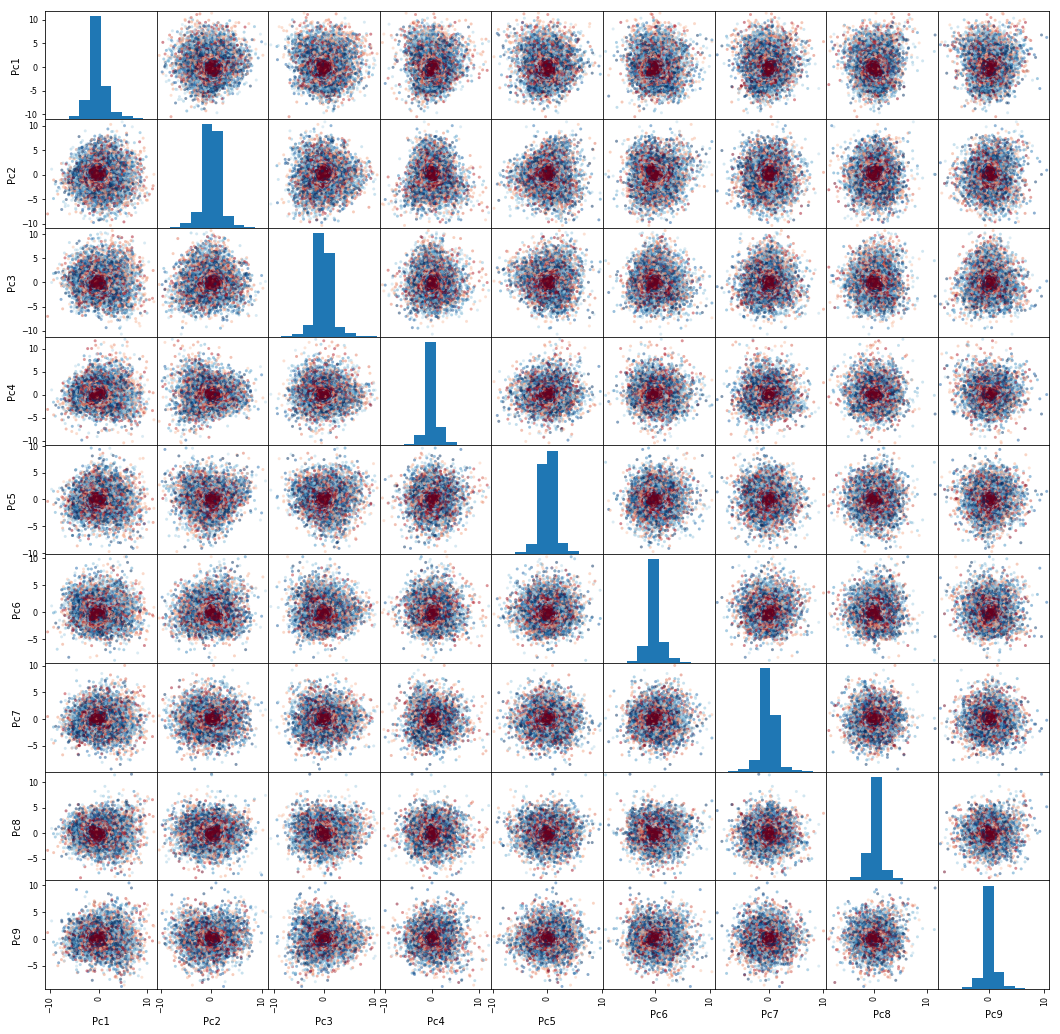

In [25]:
ax=scatter_matrix(result.drop(columns={'Score','R', 'L', 'colors'}), figsize=[18,18], marker='.', c=result.colors)
plt.show()

We cannot see any cluster. The 2D reduction of 100D is not good enough.

### Tweets representation in Word2Vec space

Represent each tweet with K components (the number of word embedding dimensions) as the mean of each word's compenents.

In [28]:
def get_tweet_vec(df,embedding, load=False):
    
    filename=pickle_files+'tweets_vec_'+str(embedding)+'.pkl'
    
    if load:
        try:
            with open(filename, 'rb') as tv:
                tweets_vec=pickle.load(tv)
            print('Tweet_vec loaded <--')

        except:
            print('Pikle not found')
            tweets_vec= np.zeros((df.shape[0],embedding)) # nb_words x K 
            zero_vec=np.zeros(embedding)

            for  idx, words in enumerate(df.Clean_tweet):
                if words:  #if not None   
                    tweets_vec[idx,:]=np.mean(word_vec.loc[words,:], axis=0) # mean over words-vectors (the weighting is included)
                else:
                    tweets_vec[idx,:]=zero_vec

            with open(filename, 'wb') as tv:
                pickle.dump(tweets_vec, tv, pickle.HIGHEST_PROTOCOL) #saving the tweet_vect
            print('Tweet_vec saved -->')
                
    else:
        tweets_vec= np.zeros((df.shape[0],embedding)) # nb_words x K 
        zero_vec=np.zeros(embedding)

        for  idx, words in enumerate(df.Clean_tweet):
            if words:  #if not None   
                tweets_vec[idx,:]=np.mean(word_vec.loc[words,:], axis=0) # mean over words-vectors (the weighting is included)
            else:
                tweets_vec[idx,:]=zero_vec

        with open(filename, 'wb') as tv:
            pickle.dump(tweets_vec, tv, pickle.HIGHEST_PROTOCOL) #saving the tweet_vect
        print('Tweet_vec saved -->')
        
    return tweets_vec

In [29]:
tweets_vec=get_tweet_vec(df, embedding, load=True)

Tweet_vec loaded <--


In [31]:
tweets_vec=standardize(tweets_vec)

In [34]:
pca = PCA(n_components=3)

tweet_vec_pca = pd.DataFrame(pca.fit_transform(model.wv.vectors),columns={'X','Y','Z'})
tweet_vec_pca['category']=df.account_category
tweet_vec_pca['colors']=tweet_vec_pca.apply(lambda row: '#ff6347' if row['category']=='RightTroll' else '#1E90FF', axis=1)
tweet_vec_pca['tweet']=df.content

In [35]:
tweet_vec_pca.head()

,X,Z,Y,category,colors,tweet
0,6.735528,2.214285,-0.353897,RightTroll,#ff6347,"""We have a sitting Democrat US Senator on tria..."
1,2.377541,-3.631651,-3.695083,RightTroll,#ff6347,Marshawn Lynch arrives to game in anti-Trump s...
2,7.187240,1.505589,0.604996,RightTroll,#ff6347,Daughter of fallen Navy Sailor delivers powerf...
3,7.168489,-3.695437,0.276368,RightTroll,#ff6347,JUST IN: President Trump dedicates Presidents ...
4,6.908217,-2.974819,-5.234756,RightTroll,#ff6347,"19,000 RESPECTING our National Anthem! #StandF..."


In [36]:
# ---- PC1 vs PC2 ---- #
pXY = figure(plot_width=500, plot_height=450)
pXY.title.text = 'Tweets topic clusters'


source_pca_R = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'RightTroll'])
pXY.scatter(x='X', y='Y', source=source_pca_R, fill_color='colors', legend='RightTroll', fill_alpha=0.6, line_color=None)

source_pca_L = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'LeftTroll'])
pXY.scatter(x='X', y='Y', source=source_pca_L, fill_color='colors', legend='LeftTroll', fill_alpha=0.6, line_color=None)


pXY.legend.location = 'top_left'
pXY.legend.click_policy='hide'
pXY.xaxis.axis_label='PC1'
pXY.yaxis.axis_label='PC2'

hover_tool=tools.HoverTool(
    tooltips=[('Tweet', '@tweet')],
    formatters={'tweet' : 'printf', },
    mode='mouse'
)

pXY.tools.append(hover_tool)

# ---- PC1 vs PC3 ---- #
pXZ = figure(plot_width=500, plot_height=450)
pXZ.title.text = 'Tweets topic clusters'


source_pca_R = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'RightTroll'])
pXZ.scatter(x='X', y='Z', source=source_pca_R, fill_color='colors', legend='RightTroll', fill_alpha=0.6, line_color=None)

source_pca_L = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'LeftTroll'])
pXZ.scatter(x='X', y='Z', source=source_pca_L, fill_color='colors', legend='LeftTroll', fill_alpha=0.6, line_color=None)


pXZ.legend.location = 'top_left'
pXZ.legend.click_policy='hide'
pXZ.xaxis.axis_label='PC1'
pXZ.yaxis.axis_label='PC3'


pXZ.tools.append(hover_tool)

output_file('Plots/Word2Vec_Tweets.html')
save(row(pXY, pXZ))

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Word2Vec_Tweets.html'

Plot can be seen [here](Plots/Word2Vec_Tweets.html)

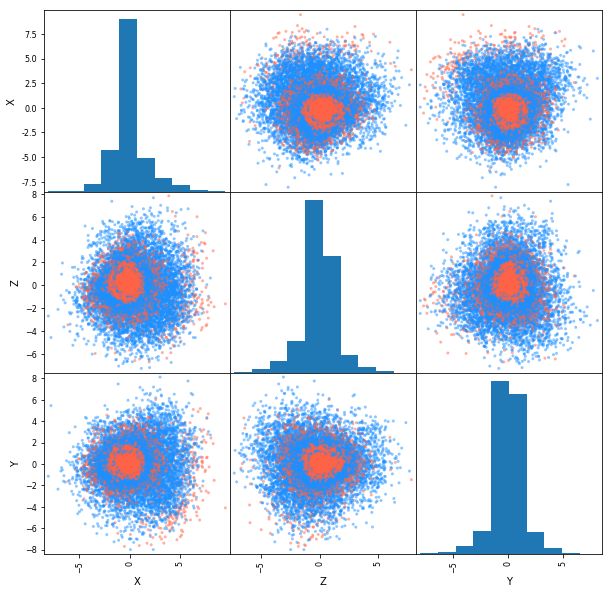

In [38]:
ax=scatter_matrix(tweet_vec_pca.drop(columns={'tweet', 'category'}), figsize=[10,10], marker='.', c=tweet_vec_pca.colors)
plt.show()

# Most frequent words & hashtags per category 

## Most frequent words, #hashtags and @mentioning

In [46]:
#Trump presidency began on the 20th of January 2017
trump_presidency = df[df.publish_date > datetime.strptime('2017-20-01', '%Y-%d-%m')]
obama_presidency = df[df.publish_date < datetime.strptime('2017-20-01', '%Y-%d-%m')]

def POTUS_count():
    '''
    Counts the number of appearance of @POTUS for trump and obama presidency by account_category
    '''
    potus_counter = Counter({'Trump-RightTroll': 0, 'Trump-LeftTroll': 0, 'Obama-RightTroll': 0, 'Obama-LeftTroll': 0})
    for row in range(len(obama_presidency)):
        if len(obama_presidency.iloc[row].Mentioned) > 0:
            for mention in obama_presidency.iloc[row].Mentioned:
                if mention == '@POTUS':
                    account_category = obama_presidency.iloc[row].account_category
                    potus_counter['Obama-'+account_category] += 1
    for row in range(len(trump_presidency)):
        if len(trump_presidency.iloc[row].Mentioned) > 0:
            for mention in trump_presidency.iloc[row].Mentioned:
                if mention == '@POTUS':
                    account_category = trump_presidency.iloc[row].account_category
                    potus_counter['Trump-'+account_category] += 1
    return potus_counter

In [47]:
potus_counter = POTUS_count()

In [48]:
# Displaying results as a confusion matrix
tot = sum(potus_counter.values())
trump_left_potus = round((100*potus_counter['Trump-LeftTroll'])/tot,2)
trump_right_potus = round((100*potus_counter['Trump-RightTroll'])/tot,2)
obama_left_potus = round((100*potus_counter['Obama-LeftTroll'])/tot,2)
obama_right_potus = round((100*potus_counter['Obama-RightTroll'])/tot,2)
potus_array = pd.DataFrame(data = {'Trump': [trump_right_potus, trump_left_potus, trump_right_potus+trump_left_potus], \
                                   'Obama': [obama_right_potus, obama_left_potus, obama_right_potus+obama_left_potus], \
                                   'Category Sum': [trump_right_potus+obama_right_potus, trump_left_potus+obama_left_potus, 100]},\
                          index = ["Right Trolls", "Left Trolls", "President Sum"])
potus_array

,Trump,Obama,Category Sum
Right Trolls,60.91,21.79,82.7
Left Trolls,4.77,12.53,17.3
President Sum,65.68,34.32,100.0


In [49]:
#Def of at and hash
top_people_right = ['@realDonaldTrump', '@POTUS', '@HillaryClinton', '@CNN', '@FoxNews', '@YouTube', '@CNNPolitics', \
             '@seanhannity', '@BreitbartNews', '@mashable']

top_people_left = ['@YouTube', '@TalibKweli', '@realDonaldTrump', '@josephjett', '@POTUS', '@deray',\
                   '@docrocktex26', '@ShaunKing', '@HillaryClinton', '@BlackGirlNerds']

top_people_expl_right = ["Donald Trump's personal account", 'President Of The United State twitter account; used by both Trump (66%) and Obama', \
                "Hillary Clinton's personal account", "CNN news official account", "FoxNews official account", \
                "YouTube official account", "CNN political twitter channel", \
                "Sean Hannity is an Fow News talk show host and conservative political commentator", \
                "Breitbart News is a far-right American news, created by Steve Bannon ex-White House Chief Strategist", \
                 "Mashable is a digital media website",]

top_people_expl_left = ["YouTube official account", "Talib Kweli is a hip hop recording artist and social activist", \
                        "Donald Trump's personal account", \
                         "Joseph Jett is a former securities trader, known for his role in the Kidder Peabody trading loss in 1994, at the time the largest trading fraud in history", \
                        'President Of The United State twitter account; used by both Trump (66%) and Obama',\
                        "DeRay Mckesson is a civil rights activist supporter of the Black Lives Matter movement", \
                         "She is a black democrat activist", \
                        "Shaun King is a writer and civil rights activist, supporting the Black Lives Matter movement", \
                        "Hillary Clinton's personal account",\
                        "Black Girl Nerds is an inclusive website promoting diversity"]


d = {'People': top_people_right, 'Explanation': top_people_expl_right}
people_explanation_right = pd.DataFrame(data=d)

d = {'People': top_people_left, 'Explanation': top_people_expl_left}
people_explanation_left = pd.DataFrame(data=d)

top_hashtag_right = ['#MAGA', '#tcot', "#PJNET", '#top', '#news', '#mar', '#topl', '#IslamKills', '#2A', '#WakeUpAmerica']

top_hashtag_left = ["#BlackLivesMatter", "#NowPlaying", "#BlackTwitter", "#news", "#PoliceBrutality", "#blacklivesmatter",\
              "#StayWoke", "#BlackSkinIsNotACrime", "#BLM", "#hiphop"]

top_hashtag_expl_right = ["Donald Trump's slogan: Make America Great Again", "Top Conservatives on Twitter", 
                   "The Patriot Journalist Network, a news network known for bombarding Twitter with thousands of posts per day about political debates", \
                   'to define', "Relative to news", "Stands for Mar-A-Lago, Trump's palm beach golf course", 
                   'To define', 'Hastag used in reaction to islamic terror attacks', 
                   "Stands for the Second Amendment of the US Constitution: The right to keep and bear arms", \
                   "To define"]

top_hashtag_expl_left = ["Black Lives Matter is an activist movement that campaigns against violence and systemic racism towards black people", \
                   "Hashtag used to share music", \
                    "Black Twitter is a cultural identity of Black Twitter users focused on issues of interest to the black community", \
                   "Relative to news", "Refers to Police brutality against the black community", \
                   "Black Lives Matter is an activist movement that campaigns against violence and systemic racism towards black people", \
                   "To stay woke is to keep informed of what going on pecifically on occasions when the media is being heavily filtered", \
                   "Refers police discrimination against african-americans", 
                   "Short for Black Lives Matter", "Refers to Hip-Hop music"]

d = {'Hashtags': top_hashtag_right, 'Explanation': top_hashtag_expl_right}
hashtag_explanation_right = pd.DataFrame(data=d)
d = {'Hashtags': top_hashtag_left, 'Explanation': top_hashtag_expl_left}
hashtag_explanation_left = pd.DataFrame(data=d)

#Getting the most popular words and hastags per category and displaying the appearance percentage per category:
top=10
popular_right=result.sort_values(by='R',ascending=False)[:top].sort_values(by='R')
popular_right['Percentage'] = (100*popular_right['R'])/len(df[df.account_category=='RightTroll'])
popular_left=result.sort_values(by='L',ascending=False)[:top].sort_values(by='L')
popular_left['Percentage'] = (100*popular_left['L'])/len(df[df.account_category=='LeftTroll'])

popular_right_h=hashtags.sort_values(by='R#',ascending=False)[:top].sort_values(by='R#')
popular_right_h = popular_right_h.join(hashtag_explanation_right.set_index('Hashtags'))
popular_right_h['Percentage'] = (100*popular_right_h['R#'])/len(df[df.account_category=='RightTroll'])
popular_left_h=hashtags.sort_values(by='L#',ascending=False)[:top].sort_values(by='L#')
popular_left_h = popular_left_h.join(hashtag_explanation_left.set_index('Hashtags'))
popular_left_h['Percentage'] = (100*popular_left_h['L#'])/len(df[df.account_category=='LeftTroll'])



popular_right_at=at_all.sort_values(by='R@',ascending=False)[:top].sort_values(by='R@')
popular_right_at = popular_right_at.join(people_explanation_right.set_index('People'))
popular_right_at['Percentage'] = (100*popular_right_at['R@'])/len(df[df.account_category=='RightTroll'])
popular_left_at=at_all.sort_values(by='L@',ascending=False)[:top].sort_values(by='L@')
popular_left_at = popular_left_at.join(people_explanation_left.set_index('People'))
popular_left_at['Percentage'] = (100*popular_left_at['L@'])/len(df[df.account_category=='LeftTroll'])





In [71]:
#Plotting
#Right trolls:
x_range=(0, popular_right['R'].max() + 1000)
sourceR=ColumnDataSource(data=popular_right)
pR = figure(plot_width=450, plot_height=350, y_range=popular_right.index.tolist(), toolbar_location=None, x_range=x_range)
pR.hbar(right='R', y='index', height=0.95, color='colors', source=sourceR)
pR.title.text = 'Popular words for RightTrolls'
pR.xaxis.axis_label= 'count'

x_range_h=(0, popular_right_h['R#'].max())
sourceR_hash=ColumnDataSource(data=popular_right_h)
pR_hash = figure(plot_width=450, plot_height=350, y_range=popular_right_h.index.tolist(), toolbar_location=None, x_range=x_range_h)
pR_hash.hbar(right='R#', y='index', height=0.95, color='colors#', source=sourceR_hash)
pR_hash.title.text = 'Popular Hastags for RightTrolls'
pR_hash.xaxis.axis_label= 'count'

x_range_at=(0, popular_right_at['R@'].max())
sourceR_at=ColumnDataSource(data=popular_right_at)
pR_at = figure(plot_width=450, plot_height=350, y_range=popular_right_at.index.tolist(), toolbar_location=None, x_range=x_range_at)
pR_at.hbar(right='R@', y='index', height=0.95, color='colors@', source=sourceR_at)
pR_at.title.text = 'Popular Mentioned Accounts for RightTrolls'
pR_at.xaxis.axis_label= 'count'



#Left trolls:

sourceL=ColumnDataSource(data=popular_left)
pL = figure(plot_width=450, plot_height=350, y_range=popular_left.index.tolist(), toolbar_location=None, x_range=x_range) 
pL.hbar(right='L', y='index', height=0.95, color='colors', source=sourceL, )
pL.title.text = 'Popular words for LeftTrolls'
pL.xaxis.axis_label= 'count'



sourceL_hash=ColumnDataSource(data=popular_left_h)
pL_hash = figure(plot_width=450, plot_height=350, y_range=popular_left_h.index.tolist(), toolbar_location=None, x_range=x_range_h)
pL_hash.hbar(right='L#', y='index', height=0.95, color='colors#', source=sourceL_hash)
pL_hash.title.text = 'Popular Hastags for LeftTrolls'
pL_hash.xaxis.axis_label= 'count'



sourceL_at=ColumnDataSource(data=popular_left_at)
pL_at = figure(plot_width=450, plot_height=350, y_range=popular_left_at.index.tolist(), toolbar_location=None, x_range=x_range_at)
pL_at.hbar(right='L@', y='index', height=0.95, color='colors@', source=sourceL_at)
pL_at.title.text = 'Popular Mentioned Accounts for LeftTrolls'
pL_at.xaxis.axis_label= 'count'




#hover settings
hover_tool_expl_at=tools.HoverTool(
    tooltips=[('Orientation', '@Score'), 
             ('Explanation', '@Explanation'), 
             ('Category', '@Percentage %')],
    formatters={'Score' : 'printf', 
               'Explanation' : 'printf',
               'Percentage' : 'printf'},
    mode='mouse', 
    #attachment = 'right'
)

#hover settings
hover_tool_expl_h=tools.HoverTool(
    tooltips=[('Orientation', '@Score'), 
             ('Explanation', '@Explanation'), 
             ('Category', '@Percentage %')],
    formatters={'Score' : 'printf', 
               'Explanation' : 'printf',
               'Percentage' : 'printf'},
    mode='mouse', 
    attachment = 'below'
)

hover_tool=tools.HoverTool(
    tooltips=[('Orientation', '@Score'), 
             ('Category', '@Percentage %')],
    formatters={'Score' : 'printf',
               'Percentage' : 'printf'},
    mode='mouse', 
    attachment = 'right'
)


pL.tools.append(hover_tool)
pR.tools.append(hover_tool)
pR_hash.tools.append(hover_tool_expl_h)
pL_hash.tools.append(hover_tool_expl_h)
pR_at.tools.append(hover_tool_expl_at)
pL_at.tools.append(hover_tool_expl_at)

pL.xaxis[0].formatter = PrintfTickFormatter(format="%4.1e")
pR.xaxis[0].formatter = PrintfTickFormatter(format="%4.1e")
#output_notebook()
output_file(plot_files+'Top_Word_hash_at.html')
save(gridplot([[pR,pL], [pR_hash, pL_hash], [pR_at, pL_at]]))

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Top_Word_hash_at.html'

The plot can be seen [here](Plots/Top_Word_hash_at.html)

In [70]:
output_file(plot_files+'Top_words.html')
save(row([pL,pR]))              

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Top_words.html'

In [68]:
output_file(plot_files+'Top_hashtags.html')
save(row([pL_hash, pR_hash]))

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Top_hashtags.html'

In [69]:
output_file(plot_files+'Top_at.html')
save(row([pL_at, pR_at]))

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Top_at.html'

## Top hashtag per day

In [ ]:
#Getting sum of tweets by account_cat and publish_date
df_plot = pd.DataFrame(df.groupby(by=["account_category", "publish_date"]).content.agg("count"))
df_plot = df_plot.unstack(level=0)

#Dataframe with the most popular hashtag and count
df_hash = df[['publish_date', 'account_category', 'hashtags']].copy()
df_hash.set_index(["account_category", "publish_date"], inplace=True)

hash_per_day = (df_hash.hashtags.apply(pd.Series)
              .stack()
              .reset_index(level=2, drop=True)
              .to_frame('hashtags'))
hash_per_day['count'] = 1

#Making every strong lower cap
hash_per_day.hashtags = hash_per_day.hashtags.str.lower()
#Counting the top hashtags per day
top_hash_per_day = hash_per_day.groupby(["account_category", "publish_date", "hashtags"]).agg("count")
#Releasing hashtag from index
top_hash_per_day = top_hash_per_day.reset_index(level=2)
#selecting the max hashtags per day
top_hash_per_day = top_hash_per_day.groupby(by=["account_category", "publish_date"]).max()
#Releasing account_cat from index
top_hash_per_day = top_hash_per_day.unstack(level=0)

In [ ]:
#merging top hash per day and and sum of tweets
final_plot = pd.merge(df_plot, top_hash_per_day, left_index=True, right_index=True)
final_plot.rename(columns={"content": "total_daily_tweets", "count": "top_hashtag_count"}, inplace=True)
#Separating left and righ
df_plot_left = pd.DataFrame(data={'total_daily_tweets': final_plot["total_daily_tweets"]["LeftTroll"],\
                   'top_hashtag': final_plot["hashtags"]["LeftTroll"],\
                   'top_hashtag_count': final_plot["top_hashtag_count"]["LeftTroll"]})
df_plot_right = pd.DataFrame(data={'total_daily_tweets': final_plot["total_daily_tweets"]["RightTroll"],\
                   'top_hashtag': final_plot["hashtags"]["RightTroll"],\
                   'top_hashtag_count': final_plot["top_hashtag_count"]["RightTroll"]})

#filling nans with strings
df_plot_left.total_daily_tweets.fillna(value="No LeftTroll tweet", inplace=True)
df_plot_left.top_hashtag.fillna(value="No LeftTroll hashtag", inplace=True)
df_plot_left.top_hashtag_count.fillna(value="No LeftTroll hashtag", inplace=True)
df_plot_right.total_daily_tweets.fillna(value="No RightTroll tweet", inplace=True)
df_plot_right.top_hashtag.fillna(value="No RightTroll hashtag", inplace=True)
df_plot_right.top_hashtag_count.fillna(value="No RightTroll hashtag", inplace=True)

**Plotting**

In [ ]:
#tweet plot
p = figure(plot_width=1000, plot_height=400, x_axis_type='datetime', toolbar_location=None)
p.title.text = 'Tweet density'
p.yaxis.axis_label = 'Number of tweets'

cat_color = ["tomato", "dodgerblue"]

source = ColumnDataSource(data=df_plot_left)
pleft = p.line(x='publish_date', y='total_daily_tweets', source=source,\
            line_width=2, alpha=0.8, legend="LeftTroll", color=cat_color[1])

hover_tool_left=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%b %d, %Y}'),
        ('Number of tweets','@total_daily_tweets'),
        ('Top trending hashtag','@top_hashtag'),
        ('Top hashtag count','@top_hashtag_count')],

    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'total_daily_tweets' : 'printf', 
        'top_hashtag' : 'printf', 
        'top_hashtag_count' : 'printf'},

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline', 
    attachment='below',
    renderers = [pleft]
)

p.tools.append(hover_tool_left)


source = ColumnDataSource(data=df_plot_right)
pright = p.line(x='publish_date', y='total_daily_tweets', source=source,\
            line_width=2, alpha=0.8, legend="RightTroll", color=cat_color[0])

p.legend.location = 'top_left'
p.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%b %d, %Y}'),
        ('Number of tweets','@total_daily_tweets'),
        ('Top trending hashtag','@top_hashtag'),
        ('Top hashtag count','@top_hashtag_count')],

    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'total_daily_tweets' : 'printf', 
        'top_hashtag' : 'printf', 
        'top_hashtag_count' : 'printf'},

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline', 
    attachment='above',
    renderers = [pright]
)
p.tools.append(hover_tool)

#output_notebook()

In [ ]:
#show(p)
output_file(plot_files+'TopHashthag_perday.html')
save(p)

The plot can be seen [here](Plots/TopHashtag_perday.html)